# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В моем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import warnings

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import sklearn
import seaborn as sns

from datetime import timedelta
from catboost import CatBoostRegressor, cv, Pool
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    cross_val_score, 
    GridSearchCV,
    RepeatedKFold, 
    StratifiedShuffleSplit, 
    train_test_split
)
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from xgboost import XGBRegressor

In [2]:
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

SEED = 123

In [3]:
auto = pd.read_csv('/datasets/autos.csv')

In [4]:
def get_info(df):
    display(df.shape)
    display(df.head())
    display(df.info())
    display(df.describe())
    display(df.isna().sum())

In [5]:
get_info(auto)

(354369, 16)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

***Описание данных:***
- DateCrawled — дата скачивания анкеты из базы
- Price — цена (евро)
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

***Вывод:***
- датасет `auto` содержит 354 369 строк и 16 столбцов;
- колонки `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired` имеют пропущенные значения: их необходимо проанализировать и обработать;
- названия столбцов не имеют "змеиного_регистра" - переименую колонки для лучшего восприятия;
- столбцы `DateCrawled`, `DateCreated`, `LastSeen` содержат в себе даты, приведу значения в этих столбцах к типу `datetime`;
- признаки `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Brand` являются категориальными;
- `Price` - целевой признак.

## Предобработка данных

### Переименование столбцов

In [6]:
auto.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower() for name in auto.columns]

In [7]:
auto.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### Преобразование типов данных

In [8]:
auto['date_crawled'] = pd.to_datetime(auto['date_crawled'])
auto['date_created'] = pd.to_datetime(auto['date_created'])
auto['last_seen'] = pd.to_datetime(auto['last_seen'])

### Обработка пропущенных значений

Колонки тип кузова `vehicle_type`, тип коробки передач`gearbox`, модель автомобиля `model`, тип топлива `fuel_type` имеют пропущенные значения. Пропуски в этих столбцах заполню группировкой по бренду автомобиля и вычислением часто встречаемых показателей для каждого бренда.

Значения в столбце `not_repaired` подтверждают, что машина была в ремонте - `yes`; не ремонтировалась - `no`. Пропуски в этой колонке могут говорить о том, что пользователь при заполнении анкеты оставил это поле пустым, так как его машина не была в ремонте, но данная гипотеза требует подтверждения от заказчика, поэтому я заполню пропущенные значения `other`. 

In [9]:
# обработка пропусков в столбце not_repaired
auto['not_repaired'] = auto['not_repaired'].fillna('other')

In [10]:
# функция для группировки по бренду и вычисления часто встречаемых показателей для каждого бренда
def calc_replacement(column_name):
    temp = pd.pivot_table(
        auto, index=['brand', column_name], values=['date_created'], aggfunc='count'
    ).reset_index()
    ids_of_max = temp.groupby('brand')['date_created'].idxmax()
    return dict(temp.loc[ids_of_max][['brand', column_name]].values)

In [11]:
columns_to_preprocess = ['vehicle_type', 'gearbox', 'model', 'fuel_type']
mapping_by_brand = {}
for column_name in columns_to_preprocess:
    mapping_by_brand[column_name] = calc_replacement(column_name)

In [12]:
list(mapping_by_brand.items())[:5]

[('vehicle_type',
  {'alfa_romeo': 'sedan',
   'audi': 'wagon',
   'bmw': 'sedan',
   'chevrolet': 'small',
   'chrysler': 'bus',
   'citroen': 'small',
   'dacia': 'wagon',
   'daewoo': 'small',
   'daihatsu': 'small',
   'fiat': 'small',
   'ford': 'small',
   'honda': 'sedan',
   'hyundai': 'small',
   'jaguar': 'sedan',
   'jeep': 'suv',
   'kia': 'suv',
   'lada': 'suv',
   'lancia': 'small',
   'land_rover': 'suv',
   'mazda': 'sedan',
   'mercedes_benz': 'sedan',
   'mini': 'small',
   'mitsubishi': 'sedan',
   'nissan': 'small',
   'opel': 'small',
   'peugeot': 'small',
   'porsche': 'convertible',
   'renault': 'small',
   'rover': 'sedan',
   'saab': 'sedan',
   'seat': 'small',
   'skoda': 'wagon',
   'smart': 'small',
   'sonstige_autos': 'sedan',
   'subaru': 'wagon',
   'suzuki': 'small',
   'toyota': 'small',
   'trabant': 'sedan',
   'volkswagen': 'sedan',
   'volvo': 'wagon'}),
 ('gearbox',
  {'alfa_romeo': 'manual',
   'audi': 'manual',
   'bmw': 'manual',
   'chevro

In [13]:
def replace_null(row):
    brand_name = row['brand']
    for column_name in columns_to_preprocess:
        if pd.isna(row[column_name]):
            row[column_name] = mapping_by_brand[column_name].get(brand_name)
    return row

In [14]:
auto = auto.apply(replace_null, axis=1)

In [15]:
auto.isna().sum()

date_crawled             0
price                    0
vehicle_type             0
registration_year        0
gearbox                  0
power                    0
model                 3374
kilometer                0
registration_month       0
fuel_type                0
brand                    0
not_repaired             0
date_created             0
number_of_pictures       0
postal_code              0
last_seen                0
dtype: int64

У бренда `sonstige_autos` для всех моделей автомобиля в колонке стоят пропущенные значения. Таких строк 3374. Чтобы не удалять данные, заполню пропуски в столбце `model` значением `other`.

In [16]:
auto.loc[pd.isna(auto['model'])].head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
59,2016-03-29 15:48:15,1,suv,1994,manual,286,None,150000,11,petrol,sonstige_autos,other,2016-03-29,0,53721,2016-04-06 01:44:38
306,2016-03-21 14:38:37,200,sedan,2009,manual,0,None,10000,0,petrol,sonstige_autos,other,2016-03-21,0,6493,2016-03-24 02:47:34
431,2016-03-20 20:45:27,3950,small,2004,auto,5,None,70000,5,gasoline,sonstige_autos,no,2016-03-20,0,90562,2016-04-03 04:17:08
650,2016-03-30 11:55:46,15000,coupe,1971,manual,0,None,5000,4,petrol,sonstige_autos,no,2016-03-30,0,51145,2016-04-07 02:45:10
661,2016-04-01 15:56:27,9900,suv,2000,auto,250,None,150000,4,lpg,sonstige_autos,no,2016-04-01,0,17309,2016-04-07 14:56:03


In [17]:
auto['model'] = auto['model'].fillna('other')

In [18]:
# проверка на наличие пропусков
auto.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

### Обработка дубликатов

In [19]:
# проверка на наличие явных дубликатов
auto.duplicated().sum()

4

In [20]:
auto = auto.drop_duplicates().reset_index(drop=True)

In [21]:
# проверка на наличие неявных дубликатов
for column in ['vehicle_type', 'gearbox', 'model','fuel_type', 'brand']:
    print(column, sorted(auto[column].unique()), sep=': ', end='\n\n')

vehicle_type: ['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon']

gearbox: ['auto', 'manual']

model: ['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', '

В столбце с моделью автомобиля обнаружены дубликаты: `rangerover` и `range_rover`. Приведу к одному названию:

In [22]:
auto['model'] = auto['model'].replace('rangerover', 'range_rover')

### Удаление ненужных столбцов для обучения моделей

Удалю из датасета столбцы с почтовым индексом пользователя `postal_code`, количеством фотографий автомобиля `number_of_pictures` и датой скачивания анкеты из базы `date_crawled`: для моделей данные столбцы не влияют на предсказание стоимости автомобиля.

In [23]:
# проверка на то, что время скачивания анкеты должна быть больше, чем время ее создания
auto.loc[auto['date_crawled'] < auto['date_created']].shape[0]

0

In [24]:
# проверка на то, что время создания анкеты всегда меньше, чем время последней активности 
auto.loc[auto['last_seen'] < auto['date_created']].shape[0]

0

In [25]:
# проверка, что год создания анкеты больше года регистрации автомобиля
abnormal_rows = auto.loc[auto['registration_year'] > auto['date_created'].dt.year].shape[0]
abnormal_rows

14530

In [26]:
# процент аномальных значений 
round(abnormal_rows * 100 / len(auto), 3)

4.1

Примерно 4% аномальных значений по несоответствию года создания анкеты и года регистрации автомобиля. Удалю такие строки.

In [27]:
auto = auto.loc[auto['registration_year'] <= auto['date_created'].dt.year].reset_index(drop=True)

In [28]:
auto = auto.drop(['postal_code', 'number_of_pictures', 'date_crawled'], axis=1)

In [29]:
auto.shape

(339835, 13)

### Добавление новых колонок

In [30]:
for column_name in ['date_created', 'last_seen']:
    auto[f'{column_name}_year'] = auto[column_name].dt.year
    auto[f'{column_name}_month'] = auto[column_name].dt.month
    auto[f'{column_name}_day'] = auto[column_name].dt.day
    
auto = auto.drop(['date_created', 'last_seen'], axis=1)

In [31]:
auto.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created_year,date_created_month,date_created_day,last_seen_year,last_seen_month,last_seen_day
0,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,other,2016,3,24,2016,4,7
1,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes,2016,3,24,2016,4,7
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,other,2016,3,14,2016,4,5
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016,3,17,2016,3,17
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016,3,31,2016,4,6


## Исследовательский анализ данных

In [32]:
plt.rcParams['figure.figsize'] = [8, 8]
sns.set_theme(style="whitegrid")

- ***исследование целевого признака `price`***

Text(0.5, 1.0, 'Histogram of price')

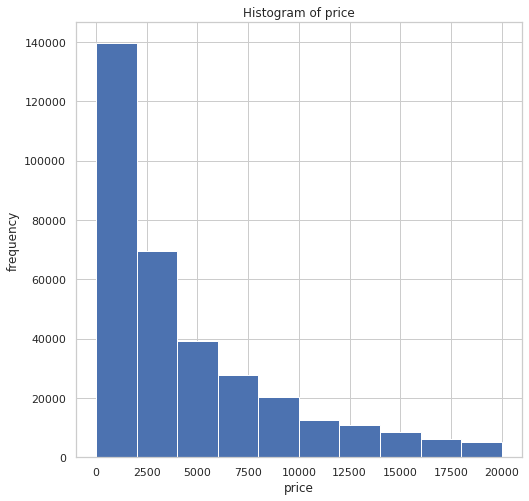

In [33]:
auto['price'].hist(range=(0, 20000))
plt.xlabel('price')
plt.ylabel('frequency')
plt.title('Histogram of price')

In [34]:
auto.query('price == 0')['price'].count() # количество строк с нулевым значением цены

10021

In [35]:
round(len(auto.query('price == 0')) * 100 / len(auto), 3) # процент аномальных значений

2.949

Доля строк с нулевым значением стоимости автомобиля от общего количества записей ~ 3% - это малая часть данных, избавлюсь от таких строк.

In [36]:
auto = auto.query('price > 0').reset_index(drop=True)

- ***исследование признака с годом регистрации автомобиля `registration_year`***

(1900.0, 2020.0)

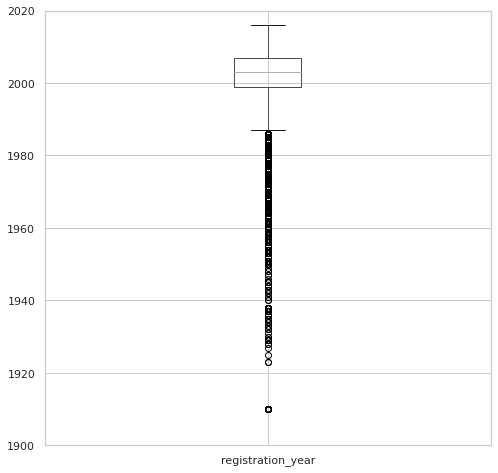

In [37]:
auto[['registration_year']].boxplot()
plt.ylim(1900, 2020)

In [38]:
# количество строк с аномальной датой регистрации автомобиля
auto.query('registration_year < 1960')['registration_year'].count() 

340

In [39]:
# процент аномальных значений
round(len(auto.query('registration_year < 1960')) * 100 / len(auto), 3) 

0.103

In [40]:
auto = auto.query('registration_year >= 1960').reset_index(drop=True)

- ***исследование признака с мощностью автомобиля `power`***

(-100.0, 1000.0)

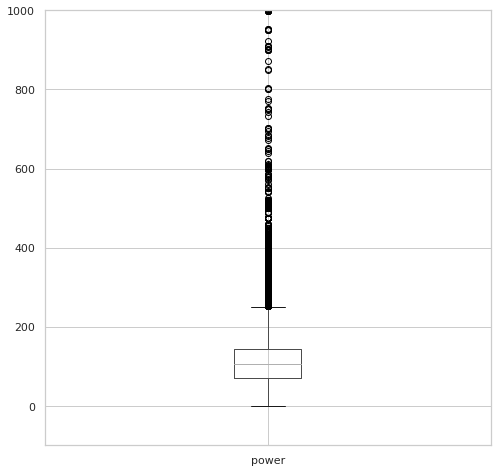

In [43]:
auto[['power']].boxplot()
plt.ylim(-100, 1000)

In [44]:
# количество строк с аномальным значением мощности
auto.query('power > 500')['power'].count()

401

In [45]:
# процент аномальных значений
round(len(auto.query('power > 500')) * 100 / len(auto), 3) 

0.122

In [46]:
auto = auto.query('power < 500').reset_index(drop=True)

- ***исследование признака с пробегом автомобиля `kilometer`***

Text(0.5, 1.0, 'Histogram of kilometer')

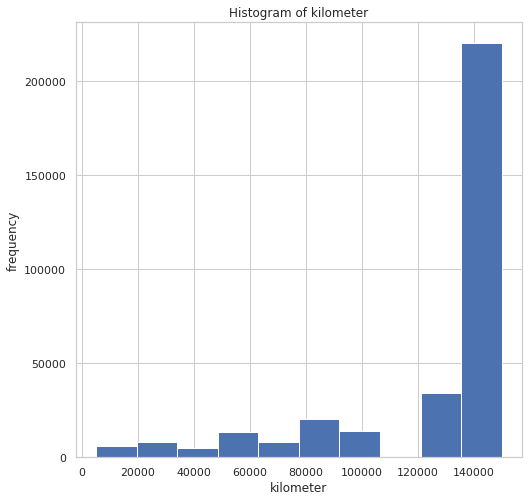

In [47]:
auto['kilometer'].hist(range=(5000, 150000))
plt.xlabel('kilometer')
plt.ylabel('frequency')
plt.title('Histogram of kilometer')

Пробег автомобилей лежит в диапазоне от 5000 км до 150000 км. Вполне реальные значения, выбросов нет.

- ***исследование признака с месяцем регистрации автомобиля `registration_month`***

Text(0.5, 1.0, 'Histogram of registration month')

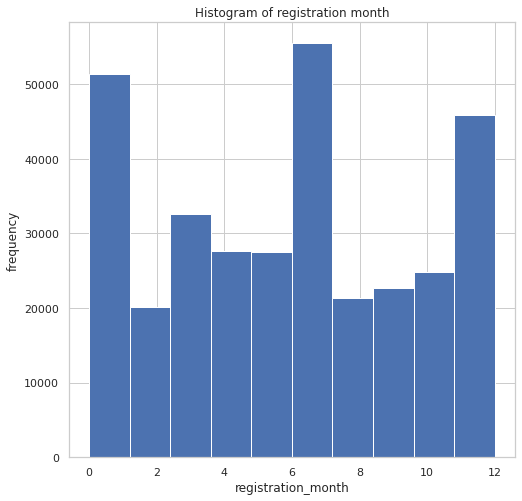

In [48]:
auto['registration_month'].hist(range=(0, 12))
plt.xlabel('registration_month')
plt.ylabel('frequency')
plt.title('Histogram of registration month')

In [49]:
# количество строк с нулевым значением месяца
auto.query('registration_month == 0')['registration_month'].count()

29424

In [50]:
# процент аномальных значений
round(len(auto.query('registration_month == 0')) * 100 / len(auto), 3)

8.933

***Вывод:*** в ходе исследовательского анализа данных были выявлены и удалены аномальные значения в количественных столбцах.

## Подготовка признаков для обучения моделей

### Разделение данных на выборки

In [51]:
features = auto.drop(['price'], axis=1)
target = auto['price']

Разделю датасет на две выборки: обучающую и тестовую в соотношении 3:1.

In [52]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=SEED
)

In [53]:
# размеры полученных выборок
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(247035, 16)
(247035,)
(82345, 16)
(82345,)


### Масштабирование признаков

In [54]:
numeric = [
    'registration_year', 'power', 'kilometer',
    'registration_month', 'date_created_year', 
    'date_created_month', 'date_created_day', 
    'last_seen_year', 'last_seen_month', 
    'last_seen_day'
]

In [55]:
scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [56]:
display(features_train.head())
display(features_test.head())

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created_year,date_created_month,date_created_day,last_seen_year,last_seen_month,last_seen_day
280021,suv,0.990157,manual,0.288344,tucson,0.655172,0.50,petrol,hyundai,no,1.0,0.181818,1.000000,0.0,1.0,0.100000
197821,sedan,0.993110,manual,0.249489,1er,0.517241,0.25,petrol,bmw,no,1.0,0.181818,0.366667,0.0,1.0,0.166667
244219,small,0.981299,manual,0.102249,polo,1.000000,0.50,petrol,volkswagen,no,1.0,0.181818,0.266667,0.0,1.0,0.133333
166404,wagon,0.990157,manual,0.000000,corsa,1.000000,0.25,gasoline,opel,other,1.0,0.181818,0.200000,0.0,0.0,0.433333
121496,convertible,0.977362,manual,0.153374,golf,1.000000,0.50,petrol,volkswagen,no,1.0,0.181818,0.766667,0.0,1.0,0.200000


,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created_year,date_created_month,date_created_day,last_seen_year,last_seen_month,last_seen_day
25443,small,0.997047,manual,0.153374,up,0.103448,0.500000,petrol,volkswagen,no,1.0,0.272727,0.033333,0.0,1.0,0.100000
37136,small,0.992126,manual,0.157464,punto,0.655172,1.000000,petrol,fiat,no,1.0,0.181818,0.866667,0.0,1.0,0.166667
208836,bus,0.993110,manual,0.163599,caddy,1.000000,0.500000,petrol,volkswagen,no,1.0,0.181818,0.433333,0.0,0.0,0.500000
78568,sedan,0.988189,manual,0.216769,golf,0.379310,0.416667,petrol,volkswagen,no,1.0,0.181818,0.266667,0.0,1.0,0.133333
159274,wagon,0.989173,manual,0.292434,c_klasse,1.000000,0.500000,petrol,mercedes_benz,no,1.0,0.181818,0.133333,0.0,0.0,0.500000


### Кодирование категориальных признаков

In [57]:
cat_columns = [
    'vehicle_type', 'gearbox',
    'model','fuel_type', 'brand',
    'not_repaired'
]

In [58]:
for cat in cat_columns:
    features_train[cat] = features_train[cat].astype('category')
    features_test[cat] = features_test[cat].astype('category')

- обучающая выборка:

In [59]:
features_train_encoder = features_train.loc[:]

encoder = OneHotEncoder(handle_unknown='error', drop='first')
encoder.fit(features_train_encoder[cat_columns])
features_train_encoded = encoder.transform(features_train_encoder[cat_columns]).toarray()
features_train_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [60]:
features_train_df = pd.DataFrame(
    features_train_encoded, 
    columns=encoder.get_feature_names(cat_columns),
    index=features_train.index
)
features_train_df.head()

,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_601,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,model_a4,model_a5,model_a6,model_a8,model_a_klasse,model_accord,model_agila,model_alhambra,model_almera,model_altea,model_amarok,model_antara,model_arosa,model_astra,model_auris,model_avensis,model_aveo,model_aygo,model_b_klasse,model_b_max,model_beetle,model_berlingo,model_bora,model_boxster,model_bravo,model_c1,model_c2,model_c3,model_c4,model_c5,model_c_klasse,model_c_max,model_c_reihe,model_caddy,model_calibra,model_captiva,model_carisma,model_carnival,model_cayenne,model_cc,model_ceed,model_charade,model_cherokee,model_citigo,model_civic,model_cl,model_clio,model_clk,model_clubman,model_colt,model_combo,model_cooper,model_cordoba,model_corolla,model_corsa,model_cr_reihe,model_croma,model_crossfire,model_cuore,model_cx_reihe,model_defender,model_delta,model_discovery,model_doblo,model_ducato,model_duster,model_e_klasse,model_elefantino,model_eos,model_escort,model_espace,model_exeo,model_fabia,model_fiesta,model_focus,model_forester,model_forfour,model_fortwo,model_fox,model_freelander,model_fusion,model_g_klasse,model_galant,model_galaxy,model_getz,model_gl,model_glk,model_golf,model_grand,model_i3,model_i_reihe,model_ibiza,model_impreza,model_insignia,model_jazz,model_jetta,model_jimny,model_juke,model_justy,model_ka,model_kadett,model_kaefer,model_kalina,model_kalos,model_kangoo,model_kappa,model_kuga,model_laguna,model_lancer,model_lanos,model_legacy,model_leon,model_lodgy,model_logan,model_lupo,model_lybra,model_m_klasse,model_m_reihe,model_materia,model_matiz,model_megane,model_meriva,model_micra,model_mii,model_modus,model_mondeo,model_move,model_musa,model_mustang,model_mx_reihe,model_navara,model_niva,model_note,model_nubira,model_octavia,model_omega,model_one,model_other,model_outlander,model_pajero,model_panda,model_passat,model_phaeton,model_picanto,model_polo,model_primera,model_ptcruiser,model_punto,model_q3,model_q5,model_q7,model_qashqai,model_r19,model_range_rover,model_range_rover_evoque,model_range_rover_sport,model_rav,model_rio,model_roadster,model_roomster,model_rx_reihe,model_s60,model_s_klasse,model_s_max,model_s_type,model_samara,model_sandero,model_santa,model_scenic,model_scirocco,model_seicento,model_serie_1,model_serie_2,model_serie_3,model_sharan,model_signum,model_sirion,model_sl,model_slk,model_sorento,model_spark,model_spider,model_sportage,model_sprinter,model_stilo,model_superb,model_swift,model_terios,model_tigra,model_tiguan,model_toledo,model_touareg,model_touran,model_transit,model_transporter,model_tt,model_tucson,model_twingo,model_up,model_v40,model_v50,model_v60,model_v70,model_v_klasse,model_vectra,model_verso,model_viano,model_vito,model_vivaro,model_voyager,model_wrangler,model_x_reihe,model_x_trail,model_x_type,model_xc_reihe,model_yaris,model_yeti,model_ypsilon,model_z_reihe,model_zafira,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_other,not_repaired_yes
280021,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [61]:
features_train_drop = features_train.drop(cat_columns, axis=1)
features_train_drop.head()

,registration_year,power,kilometer,registration_month,date_created_year,date_created_month,date_created_day,last_seen_year,last_seen_month,last_seen_day
280021,0.990157,0.288344,0.655172,0.50,1.0,0.181818,1.000000,0.0,1.0,0.100000
197821,0.993110,0.249489,0.517241,0.25,1.0,0.181818,0.366667,0.0,1.0,0.166667
244219,0.981299,0.102249,1.000000,0.50,1.0,0.181818,0.266667,0.0,1.0,0.133333
166404,0.990157,0.000000,1.000000,0.25,1.0,0.181818,0.200000,0.0,0.0,0.433333
121496,0.977362,0.153374,1.000000,0.50,1.0,0.181818,0.766667,0.0,1.0,0.200000


In [62]:
features_train_ohe = pd.concat((features_train_drop, features_train_df), axis=1)
features_train_ohe.head()

,registration_year,power,kilometer,registration_month,date_created_year,date_created_month,date_created_day,last_seen_year,last_seen_month,last_seen_day,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_601,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,model_a4,model_a5,model_a6,model_a8,model_a_klasse,model_accord,model_agila,model_alhambra,model_almera,model_altea,model_amarok,model_antara,model_arosa,model_astra,model_auris,model_avensis,model_aveo,model_aygo,model_b_klasse,model_b_max,model_beetle,model_berlingo,model_bora,model_boxster,model_bravo,model_c1,model_c2,model_c3,model_c4,model_c5,model_c_klasse,model_c_max,model_c_reihe,model_caddy,model_calibra,model_captiva,model_carisma,model_carnival,model_cayenne,model_cc,model_ceed,model_charade,model_cherokee,model_citigo,model_civic,model_cl,model_clio,model_clk,model_clubman,model_colt,model_combo,model_cooper,model_cordoba,model_corolla,model_corsa,model_cr_reihe,model_croma,model_crossfire,model_cuore,model_cx_reihe,model_defender,model_delta,model_discovery,model_doblo,model_ducato,model_duster,model_e_klasse,model_elefantino,model_eos,model_escort,model_espace,model_exeo,model_fabia,model_fiesta,model_focus,model_forester,model_forfour,model_fortwo,model_fox,model_freelander,model_fusion,model_g_klasse,model_galant,model_galaxy,model_getz,model_gl,model_glk,model_golf,model_grand,model_i3,model_i_reihe,model_ibiza,model_impreza,model_insignia,model_jazz,model_jetta,model_jimny,model_juke,model_justy,model_ka,model_kadett,model_kaefer,model_kalina,model_kalos,model_kangoo,model_kappa,model_kuga,model_laguna,model_lancer,model_lanos,model_legacy,model_leon,model_lodgy,model_logan,model_lupo,model_lybra,model_m_klasse,model_m_reihe,model_materia,model_matiz,model_megane,model_meriva,model_micra,model_mii,model_modus,model_mondeo,model_move,model_musa,model_mustang,model_mx_reihe,model_navara,model_niva,model_note,model_nubira,model_octavia,model_omega,model_one,model_other,model_outlander,model_pajero,model_panda,model_passat,model_phaeton,model_picanto,model_polo,model_primera,model_ptcruiser,model_punto,model_q3,model_q5,model_q7,model_qashqai,model_r19,model_range_rover,model_range_rover_evoque,model_range_rover_sport,model_rav,model_rio,model_roadster,model_roomster,model_rx_reihe,model_s60,model_s_klasse,model_s_max,model_s_type,model_samara,model_sandero,model_santa,model_scenic,model_scirocco,model_seicento,model_serie_1,model_serie_2,model_serie_3,model_sharan,model_signum,model_sirion,model_sl,model_slk,model_sorento,model_spark,model_spider,model_sportage,model_sprinter,model_stilo,model_superb,model_swift,model_terios,model_tigra,model_tiguan,model_toledo,model_touareg,model_touran,model_transit,model_transporter,model_tt,model_tucson,model_twingo,model_up,model_v40,model_v50,model_v60,model_v70,model_v_klasse,model_vectra,model_verso,model_viano,model_vito,model_vivaro,model_voyager,model_wrangler,model_x_reihe,model_x_trail,model_x_type,model_xc_reihe,model_yaris,model_yeti,model_ypsilon,model_z_reihe,model_zafira,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen

- тестовая выборка:

In [63]:
features_test_encoder = features_test.loc[:]
features_test_encoded = encoder.transform(features_test_encoder[cat_columns]).toarray()
features_test_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [64]:
features_test_df = pd.DataFrame(
    features_test_encoded, 
    columns=encoder.get_feature_names(cat_columns),
    index=features_test.index
)
features_test_df.head()

,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_601,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,model_a4,model_a5,model_a6,model_a8,model_a_klasse,model_accord,model_agila,model_alhambra,model_almera,model_altea,model_amarok,model_antara,model_arosa,model_astra,model_auris,model_avensis,model_aveo,model_aygo,model_b_klasse,model_b_max,model_beetle,model_berlingo,model_bora,model_boxster,model_bravo,model_c1,model_c2,model_c3,model_c4,model_c5,model_c_klasse,model_c_max,model_c_reihe,model_caddy,model_calibra,model_captiva,model_carisma,model_carnival,model_cayenne,model_cc,model_ceed,model_charade,model_cherokee,model_citigo,model_civic,model_cl,model_clio,model_clk,model_clubman,model_colt,model_combo,model_cooper,model_cordoba,model_corolla,model_corsa,model_cr_reihe,model_croma,model_crossfire,model_cuore,model_cx_reihe,model_defender,model_delta,model_discovery,model_doblo,model_ducato,model_duster,model_e_klasse,model_elefantino,model_eos,model_escort,model_espace,model_exeo,model_fabia,model_fiesta,model_focus,model_forester,model_forfour,model_fortwo,model_fox,model_freelander,model_fusion,model_g_klasse,model_galant,model_galaxy,model_getz,model_gl,model_glk,model_golf,model_grand,model_i3,model_i_reihe,model_ibiza,model_impreza,model_insignia,model_jazz,model_jetta,model_jimny,model_juke,model_justy,model_ka,model_kadett,model_kaefer,model_kalina,model_kalos,model_kangoo,model_kappa,model_kuga,model_laguna,model_lancer,model_lanos,model_legacy,model_leon,model_lodgy,model_logan,model_lupo,model_lybra,model_m_klasse,model_m_reihe,model_materia,model_matiz,model_megane,model_meriva,model_micra,model_mii,model_modus,model_mondeo,model_move,model_musa,model_mustang,model_mx_reihe,model_navara,model_niva,model_note,model_nubira,model_octavia,model_omega,model_one,model_other,model_outlander,model_pajero,model_panda,model_passat,model_phaeton,model_picanto,model_polo,model_primera,model_ptcruiser,model_punto,model_q3,model_q5,model_q7,model_qashqai,model_r19,model_range_rover,model_range_rover_evoque,model_range_rover_sport,model_rav,model_rio,model_roadster,model_roomster,model_rx_reihe,model_s60,model_s_klasse,model_s_max,model_s_type,model_samara,model_sandero,model_santa,model_scenic,model_scirocco,model_seicento,model_serie_1,model_serie_2,model_serie_3,model_sharan,model_signum,model_sirion,model_sl,model_slk,model_sorento,model_spark,model_spider,model_sportage,model_sprinter,model_stilo,model_superb,model_swift,model_terios,model_tigra,model_tiguan,model_toledo,model_touareg,model_touran,model_transit,model_transporter,model_tt,model_tucson,model_twingo,model_up,model_v40,model_v50,model_v60,model_v70,model_v_klasse,model_vectra,model_verso,model_viano,model_vito,model_vivaro,model_voyager,model_wrangler,model_x_reihe,model_x_trail,model_x_type,model_xc_reihe,model_yaris,model_yeti,model_ypsilon,model_z_reihe,model_zafira,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_other,not_repaired_yes
25443,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [65]:
features_test_drop = features_test.drop(cat_columns, axis=1)
features_test_drop.head()

,registration_year,power,kilometer,registration_month,date_created_year,date_created_month,date_created_day,last_seen_year,last_seen_month,last_seen_day
25443,0.997047,0.153374,0.103448,0.500000,1.0,0.272727,0.033333,0.0,1.0,0.100000
37136,0.992126,0.157464,0.655172,1.000000,1.0,0.181818,0.866667,0.0,1.0,0.166667
208836,0.993110,0.163599,1.000000,0.500000,1.0,0.181818,0.433333,0.0,0.0,0.500000
78568,0.988189,0.216769,0.379310,0.416667,1.0,0.181818,0.266667,0.0,1.0,0.133333
159274,0.989173,0.292434,1.000000,0.500000,1.0,0.181818,0.133333,0.0,0.0,0.500000


In [66]:
features_test_ohe = pd.concat((features_test_drop, features_test_df), axis=1)
features_test_ohe.head()

,registration_year,power,kilometer,registration_month,date_created_year,date_created_month,date_created_day,last_seen_year,last_seen_month,last_seen_day,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_601,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,model_a4,model_a5,model_a6,model_a8,model_a_klasse,model_accord,model_agila,model_alhambra,model_almera,model_altea,model_amarok,model_antara,model_arosa,model_astra,model_auris,model_avensis,model_aveo,model_aygo,model_b_klasse,model_b_max,model_beetle,model_berlingo,model_bora,model_boxster,model_bravo,model_c1,model_c2,model_c3,model_c4,model_c5,model_c_klasse,model_c_max,model_c_reihe,model_caddy,model_calibra,model_captiva,model_carisma,model_carnival,model_cayenne,model_cc,model_ceed,model_charade,model_cherokee,model_citigo,model_civic,model_cl,model_clio,model_clk,model_clubman,model_colt,model_combo,model_cooper,model_cordoba,model_corolla,model_corsa,model_cr_reihe,model_croma,model_crossfire,model_cuore,model_cx_reihe,model_defender,model_delta,model_discovery,model_doblo,model_ducato,model_duster,model_e_klasse,model_elefantino,model_eos,model_escort,model_espace,model_exeo,model_fabia,model_fiesta,model_focus,model_forester,model_forfour,model_fortwo,model_fox,model_freelander,model_fusion,model_g_klasse,model_galant,model_galaxy,model_getz,model_gl,model_glk,model_golf,model_grand,model_i3,model_i_reihe,model_ibiza,model_impreza,model_insignia,model_jazz,model_jetta,model_jimny,model_juke,model_justy,model_ka,model_kadett,model_kaefer,model_kalina,model_kalos,model_kangoo,model_kappa,model_kuga,model_laguna,model_lancer,model_lanos,model_legacy,model_leon,model_lodgy,model_logan,model_lupo,model_lybra,model_m_klasse,model_m_reihe,model_materia,model_matiz,model_megane,model_meriva,model_micra,model_mii,model_modus,model_mondeo,model_move,model_musa,model_mustang,model_mx_reihe,model_navara,model_niva,model_note,model_nubira,model_octavia,model_omega,model_one,model_other,model_outlander,model_pajero,model_panda,model_passat,model_phaeton,model_picanto,model_polo,model_primera,model_ptcruiser,model_punto,model_q3,model_q5,model_q7,model_qashqai,model_r19,model_range_rover,model_range_rover_evoque,model_range_rover_sport,model_rav,model_rio,model_roadster,model_roomster,model_rx_reihe,model_s60,model_s_klasse,model_s_max,model_s_type,model_samara,model_sandero,model_santa,model_scenic,model_scirocco,model_seicento,model_serie_1,model_serie_2,model_serie_3,model_sharan,model_signum,model_sirion,model_sl,model_slk,model_sorento,model_spark,model_spider,model_sportage,model_sprinter,model_stilo,model_superb,model_swift,model_terios,model_tigra,model_tiguan,model_toledo,model_touareg,model_touran,model_transit,model_transporter,model_tt,model_tucson,model_twingo,model_up,model_v40,model_v50,model_v60,model_v70,model_v_klasse,model_vectra,model_verso,model_viano,model_vito,model_vivaro,model_voyager,model_wrangler,model_x_reihe,model_x_trail,model_x_type,model_xc_reihe,model_yaris,model_yeti,model_ypsilon,model_z_reihe,model_zafira,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen

In [67]:
display(features_train_ohe.head())
display(features_test_ohe.head())

,registration_year,power,kilometer,registration_month,date_created_year,date_created_month,date_created_day,last_seen_year,last_seen_month,last_seen_day,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_601,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,model_a4,model_a5,model_a6,model_a8,model_a_klasse,model_accord,model_agila,model_alhambra,model_almera,model_altea,model_amarok,model_antara,model_arosa,model_astra,model_auris,model_avensis,model_aveo,model_aygo,model_b_klasse,model_b_max,model_beetle,model_berlingo,model_bora,model_boxster,model_bravo,model_c1,model_c2,model_c3,model_c4,model_c5,model_c_klasse,model_c_max,model_c_reihe,model_caddy,model_calibra,model_captiva,model_carisma,model_carnival,model_cayenne,model_cc,model_ceed,model_charade,model_cherokee,model_citigo,model_civic,model_cl,model_clio,model_clk,model_clubman,model_colt,model_combo,model_cooper,model_cordoba,model_corolla,model_corsa,model_cr_reihe,model_croma,model_crossfire,model_cuore,model_cx_reihe,model_defender,model_delta,model_discovery,model_doblo,model_ducato,model_duster,model_e_klasse,model_elefantino,model_eos,model_escort,model_espace,model_exeo,model_fabia,model_fiesta,model_focus,model_forester,model_forfour,model_fortwo,model_fox,model_freelander,model_fusion,model_g_klasse,model_galant,model_galaxy,model_getz,model_gl,model_glk,model_golf,model_grand,model_i3,model_i_reihe,model_ibiza,model_impreza,model_insignia,model_jazz,model_jetta,model_jimny,model_juke,model_justy,model_ka,model_kadett,model_kaefer,model_kalina,model_kalos,model_kangoo,model_kappa,model_kuga,model_laguna,model_lancer,model_lanos,model_legacy,model_leon,model_lodgy,model_logan,model_lupo,model_lybra,model_m_klasse,model_m_reihe,model_materia,model_matiz,model_megane,model_meriva,model_micra,model_mii,model_modus,model_mondeo,model_move,model_musa,model_mustang,model_mx_reihe,model_navara,model_niva,model_note,model_nubira,model_octavia,model_omega,model_one,model_other,model_outlander,model_pajero,model_panda,model_passat,model_phaeton,model_picanto,model_polo,model_primera,model_ptcruiser,model_punto,model_q3,model_q5,model_q7,model_qashqai,model_r19,model_range_rover,model_range_rover_evoque,model_range_rover_sport,model_rav,model_rio,model_roadster,model_roomster,model_rx_reihe,model_s60,model_s_klasse,model_s_max,model_s_type,model_samara,model_sandero,model_santa,model_scenic,model_scirocco,model_seicento,model_serie_1,model_serie_2,model_serie_3,model_sharan,model_signum,model_sirion,model_sl,model_slk,model_sorento,model_spark,model_spider,model_sportage,model_sprinter,model_stilo,model_superb,model_swift,model_terios,model_tigra,model_tiguan,model_toledo,model_touareg,model_touran,model_transit,model_transporter,model_tt,model_tucson,model_twingo,model_up,model_v40,model_v50,model_v60,model_v70,model_v_klasse,model_vectra,model_verso,model_viano,model_vito,model_vivaro,model_voyager,model_wrangler,model_x_reihe,model_x_trail,model_x_type,model_xc_reihe,model_yaris,model_yeti,model_ypsilon,model_z_reihe,model_zafira,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen

,registration_year,power,kilometer,registration_month,date_created_year,date_created_month,date_created_day,last_seen_year,last_seen_month,last_seen_day,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_601,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,model_a4,model_a5,model_a6,model_a8,model_a_klasse,model_accord,model_agila,model_alhambra,model_almera,model_altea,model_amarok,model_antara,model_arosa,model_astra,model_auris,model_avensis,model_aveo,model_aygo,model_b_klasse,model_b_max,model_beetle,model_berlingo,model_bora,model_boxster,model_bravo,model_c1,model_c2,model_c3,model_c4,model_c5,model_c_klasse,model_c_max,model_c_reihe,model_caddy,model_calibra,model_captiva,model_carisma,model_carnival,model_cayenne,model_cc,model_ceed,model_charade,model_cherokee,model_citigo,model_civic,model_cl,model_clio,model_clk,model_clubman,model_colt,model_combo,model_cooper,model_cordoba,model_corolla,model_corsa,model_cr_reihe,model_croma,model_crossfire,model_cuore,model_cx_reihe,model_defender,model_delta,model_discovery,model_doblo,model_ducato,model_duster,model_e_klasse,model_elefantino,model_eos,model_escort,model_espace,model_exeo,model_fabia,model_fiesta,model_focus,model_forester,model_forfour,model_fortwo,model_fox,model_freelander,model_fusion,model_g_klasse,model_galant,model_galaxy,model_getz,model_gl,model_glk,model_golf,model_grand,model_i3,model_i_reihe,model_ibiza,model_impreza,model_insignia,model_jazz,model_jetta,model_jimny,model_juke,model_justy,model_ka,model_kadett,model_kaefer,model_kalina,model_kalos,model_kangoo,model_kappa,model_kuga,model_laguna,model_lancer,model_lanos,model_legacy,model_leon,model_lodgy,model_logan,model_lupo,model_lybra,model_m_klasse,model_m_reihe,model_materia,model_matiz,model_megane,model_meriva,model_micra,model_mii,model_modus,model_mondeo,model_move,model_musa,model_mustang,model_mx_reihe,model_navara,model_niva,model_note,model_nubira,model_octavia,model_omega,model_one,model_other,model_outlander,model_pajero,model_panda,model_passat,model_phaeton,model_picanto,model_polo,model_primera,model_ptcruiser,model_punto,model_q3,model_q5,model_q7,model_qashqai,model_r19,model_range_rover,model_range_rover_evoque,model_range_rover_sport,model_rav,model_rio,model_roadster,model_roomster,model_rx_reihe,model_s60,model_s_klasse,model_s_max,model_s_type,model_samara,model_sandero,model_santa,model_scenic,model_scirocco,model_seicento,model_serie_1,model_serie_2,model_serie_3,model_sharan,model_signum,model_sirion,model_sl,model_slk,model_sorento,model_spark,model_spider,model_sportage,model_sprinter,model_stilo,model_superb,model_swift,model_terios,model_tigra,model_tiguan,model_toledo,model_touareg,model_touran,model_transit,model_transporter,model_tt,model_tucson,model_twingo,model_up,model_v40,model_v50,model_v60,model_v70,model_v_klasse,model_vectra,model_verso,model_viano,model_vito,model_vivaro,model_voyager,model_wrangler,model_x_reihe,model_x_trail,model_x_type,model_xc_reihe,model_yaris,model_yeti,model_ypsilon,model_z_reihe,model_zafira,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen

## Подбор гиперпараметров с помощью GridSearchCV

Для решения задачи регрессии буду обучать следующие модели:
- *CatBoostRegressor;*
- *LGBMRegressor;*
- *SGDRegressor;*
- *XGBRegressor;*
- *RandomForestRegressor.*

Моделью GridSearchCV подберу наилучшие гиперпараметры.

In [68]:
"""CatBoostRegressor"""

cat_boost_model = CatBoostRegressor(
    cat_features=cat_columns, 
    random_seed=SEED,
    loss_function='RMSE',
    eval_metric='RMSE'
)

In [69]:
parameters = {
    'iterations': [100, 200],
    'early_stopping_rounds': [20],
    'depth': [2, 3, 4],
}

In [70]:
# %%time
# grid = GridSearchCV(
#     cat_boost_model, parameters, n_jobs=10,
#     pre_dispatch=8, cv=3, verbose=False,
#     scoring='neg_root_mean_squared_error'
# )
# grid.fit(features_train, target_train)

In [71]:
# grid.best_params_

**Лучшие гиперпараметры для модели CatBoostRegressor {'depth': 4, 'early_stopping_rounds': 20, 'iterations': 200}**

In [72]:
"""LGBMRegressor"""

booster = lgb.LGBMRegressor(objective="rmse", random_state=SEED)

In [73]:
parameters = {
    'learning_rate': [0.3, 0.1, 0.01],
    'max_depth': [2, 3, 4],
    'n_estimators': [100, 200],
}

In [74]:
# %%time
# grid = GridSearchCV(
#     booster, parameters, n_jobs=10,
#     pre_dispatch=8, verbose=1, cv=3,
#     scoring='neg_root_mean_squared_error'
# )
# grid.fit(features_train, target_train)

In [75]:
# grid.best_params_

**Лучшие гиперпараметры для модели LGBMRegressor {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 200}**

In [76]:
"""SGDRegressor"""

sgd_model = SGDRegressor(random_state=SEED)

In [77]:
parameters = {
    'learning_rate': ['constant'],
    'eta0': [0.3, 0.1, 0.01],
    'max_iter': [100, 200],
    'penalty': ['l2', 'l1', 'elasticnet']
}

In [78]:
# %%time
# grid = GridSearchCV(
#     sgd_model, parameters, n_jobs=10,
#     pre_dispatch=8, cv=3,
#     scoring='neg_root_mean_squared_error'
# )
# grid.fit(features_train_ohe, target_train)

In [79]:
# grid.best_params_

**Лучшие гиперпараметры для модели SGDRegressor {'eta0': 0.01, 'learning_rate': 'constant', 'max_iter': 100, 'penalty': 'l1'}**

In [80]:
"""XGBRegressor"""

xgb_model = XGBRegressor(random_state=SEED)

In [81]:
parameters = {
    'max_depth': [2, 3, 4],
    'n_estimators': [100, 200],
}

In [82]:
# %%time
# grid = GridSearchCV(
#     xgb_model, parameters, n_jobs=10,
#     pre_dispatch=8, cv=3, verbose=2,
#     scoring='neg_root_mean_squared_error'
# )
# grid.fit(features_train_ohe, target_train)

In [83]:
# grid.best_params_

**Лучшие гиперпараметры для модели XGBRegressor {'max_depth': 4, 'n_estimators': 200}**

In [84]:
"""RandomForestRegressor"""

model_random_forest = RandomForestRegressor(random_state=SEED)

In [90]:
parametrs = { 
    'n_estimators': range (20, 51, 10),
    'max_depth': range (4, 10, 2),
    'min_samples_leaf': range (2, 5)
}

In [91]:
# %%time
# grid = GridSearchCV(
#     model_random_forest, 
#     parametrs, 
#     n_jobs=10, 
#     pre_dispatch=6, 
#     verbose=2, 
#     cv=3, 
#     scoring='neg_root_mean_squared_error'
# )
# grid.fit(features_train_ohe, target_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
CPU times: user 1min 30s, sys: 788 ms, total: 1min 30s
Wall time: 28min 10s


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=123), n_jobs=10,
             param_grid={'max_depth': range(4, 10, 2),
                         'min_samples_leaf': range(2, 5),
                         'n_estimators': range(20, 51, 10)},
             pre_dispatch=6, scoring='neg_root_mean_squared_error', verbose=2)

In [92]:
# grid.best_params_

{'max_depth': 8, 'min_samples_leaf': 4, 'n_estimators': 50}

[CV] END ...max_depth=4, min_samples_leaf=2, n_estimators=40; total time= 1.0min
[CV] END ...max_depth=4, min_samples_leaf=3, n_estimators=30; total time=  48.7s
[CV] END ...max_depth=4, min_samples_leaf=4, n_estimators=20; total time=  32.8s
[CV] END ...max_depth=4, min_samples_leaf=4, n_estimators=40; total time= 1.1min
[CV] END ...max_depth=6, min_samples_leaf=2, n_estimators=40; total time= 1.7min
[CV] END ...max_depth=6, min_samples_leaf=3, n_estimators=30; total time= 1.3min
[CV] END ...max_depth=6, min_samples_leaf=4, n_estimators=20; total time=  51.8s
[CV] END ...max_depth=6, min_samples_leaf=4, n_estimators=50; total time= 2.2min
[CV] END ...max_depth=8, min_samples_leaf=2, n_estimators=50; total time= 2.9min
[CV] END ...max_depth=8, min_samples_leaf=3, n_estimators=50; total time= 2.8min
[CV] END ...max_depth=4, min_samples_leaf=2, n_estimators=40; total time= 1.0min
[CV] END ...max_depth=4, min_samples_leaf=3, n_estimators=30; total time=  48.8s
[CV] END ...max_depth=4, min

**Лучшие гиперпараметры для модели RandomForestRegressor {'max_depth': 8, 'min_samples_leaf': 4, 'n_estimators': 50}**

## Обучение моделей и применение кросс-валидации для выбора наилучшей модели

- ***CatBoostRegressor***

In [93]:
params = {
    'loss_function': 'RMSE',
    'iterations': 200,
    'early_stopping_rounds': 20,
    'random_seed': SEED,
    'depth': 4
}

cv_data = cv(
    params=params,
    pool=Pool(data=features_train, label=target_train, cat_features=cat_columns),
    fold_count=5,
    shuffle=True, 
    partition_random_seed=SEED,
    plot=True,
    stratified=False, 
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 1971.22921
bestIteration = 199

Training on fold [1/5]

bestTest = 1967.567503
bestIteration = 199

Training on fold [2/5]

bestTest = 1974.706549
bestIteration = 199

Training on fold [3/5]

bestTest = 1952.050263
bestIteration = 199

Training on fold [4/5]

bestTest = 1977.11849
bestIteration = 199



In [94]:
best_value = np.min(cv_data['test-RMSE-mean'])
best_iter = np.argmin(cv_data['test-RMSE-mean'])
print("Средняя оценка качества модели: {:.2f}+/-{:.2f} on step {}".format(
    best_value, cv_data['test-RMSE-std'][best_iter], best_iter)
     )

Средняя оценка качества модели: 1968.53+/-9.90 on step 199


- ***LGBMRegressor***

In [95]:
train_dataset = lgb.Dataset(
    features_train, label=target_train
)
test_dataset = lgb.Dataset(
    features_test, label=target_test
)

In [96]:
cv_output = lgb.cv(
    {"objective": "rmse", "verbosity": -1},
    train_set=train_dataset, num_boost_round=200,
    metrics=["rmse"],
    nfold=5,
    stratified=False,
    return_cvbooster=True,
)

In [97]:
best_value = np.min(cv_output['rmse-mean'])
best_iter = np.argmin(cv_output['rmse-mean'])
print("Средняя оценка качества модели: {:.2f}+/-{:.2f} on step {}".format(
best_value, cv_output['rmse-stdv'][best_iter], best_iter)
     )

Средняя оценка качества модели: 1588.84+/-10.47 on step 199


- ***Стохастический градиентный спуск для модели линейной регрессии (SGDRegressor)***

In [98]:
sgd_model = SGDRegressor(
    eta0=0.01,
    learning_rate='constant',
    max_iter=100,
    penalty='l1',
    random_state=SEED
)
cv = RepeatedKFold(n_splits=3, n_repeats=2, random_state=SEED)

scores = cross_val_score(
    sgd_model, features_train_ohe, target_train,
    scoring='neg_root_mean_squared_error', cv=cv, n_jobs=8
)
scores = abs(scores)
print('Средняя оценка качества модели: %.2f (%.2f)' % (scores.mean(), scores.std()))

Средняя оценка качества модели: 2920.41 (31.37)


- ***XGBRegressor***

In [99]:
xgb_model = XGBRegressor(
    n_estimators=200,
    max_depth=4,
    eta=0.3,
    random_state=SEED
)

cv = RepeatedKFold(n_splits=3, n_repeats=2, random_state=SEED)
scores = cross_val_score(
    xgb_model, features_train_ohe, target_train,
    scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1
)
scores = abs(scores)
print('Средняя оценка качества модели: %.2f (%.2f)' % (scores.mean(), scores.std()))

Средняя оценка качества модели: 1682.94 (4.78)


- ***RandomForestRegressor***

In [100]:
rf_model = RandomForestRegressor(
    max_depth=8, 
    min_samples_leaf=4,  
    n_estimators=50, 
    random_state=SEED,
    n_jobs=-1
)
scores = cross_val_score(
    rf_model, features_train_ohe, target_train, cv=5, scoring='neg_root_mean_squared_error'
)
scores = abs(scores)
print('Средняя оценка качества модели: %.2f (%.2f)' % (scores.mean(), scores.std()))

Средняя оценка качества модели: 2075.03 (17.57)


***Вывод:*** по результатам кросс-валидации лучшая оценка качества у модели `LGBMRegressor - 1588.84`. Протестирую эту модель и выведу значение RMSE.

- ***обучение и предсказание модели LGBMRegressor на тестовой выборке***

In [101]:
%%time

booster = lgb.LGBMRegressor(
    objective="rmse",
    n_estimators=200,
    learning_rate=0.3,
    max_depth=4,
    random_state=SEED
)
booster.fit(features_train, target_train, eval_set=[(features_test, target_test)], eval_metric='rmse')

[1]	valid_0's rmse: 3655.3
[2]	valid_0's rmse: 3099.72
[3]	valid_0's rmse: 2736.79
[4]	valid_0's rmse: 2490.96
[5]	valid_0's rmse: 2311.14
[6]	valid_0's rmse: 2182.37
[7]	valid_0's rmse: 2088.64
[8]	valid_0's rmse: 2019.27
[9]	valid_0's rmse: 1965.22
[10]	valid_0's rmse: 1928.08
[11]	valid_0's rmse: 1896.38
[12]	valid_0's rmse: 1873.2
[13]	valid_0's rmse: 1859.87
[14]	valid_0's rmse: 1843.45
[15]	valid_0's rmse: 1832.98
[16]	valid_0's rmse: 1822.77
[17]	valid_0's rmse: 1814.21
[18]	valid_0's rmse: 1805.2
[19]	valid_0's rmse: 1797.63
[20]	valid_0's rmse: 1791.52
[21]	valid_0's rmse: 1780.33
[22]	valid_0's rmse: 1773.21
[23]	valid_0's rmse: 1769.73
[24]	valid_0's rmse: 1763.16
[25]	valid_0's rmse: 1760.42
[26]	valid_0's rmse: 1753.9
[27]	valid_0's rmse: 1750.29
[28]	valid_0's rmse: 1745.81
[29]	valid_0's rmse: 1742.79
[30]	valid_0's rmse: 1739.54
[31]	valid_0's rmse: 1736.72
[32]	valid_0's rmse: 1730.42
[33]	valid_0's rmse: 1729.32
[34]	valid_0's rmse: 1725.71
[35]	valid_0's rmse: 1718.4

LGBMRegressor(learning_rate=0.3, max_depth=4, n_estimators=200,
              objective='rmse', random_state=123)

In [102]:
%%time

predictions_test = booster.predict(features_test)
rmse = mean_squared_error(target_test, predictions_test, squared=False)
print("RMSE для модели LGBMRegressor на тестовой выборке:", round(rmse, 2))

RMSE для модели LGBMRegressor на тестовой выборке: 1595.11
CPU times: user 1.46 s, sys: 2.6 ms, total: 1.46 s
Wall time: 141 ms


***Вывод:*** значение RMSE на тестовых данных модели `LGBMRegressor - 1595.11`.

## Анализ моделей

Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

| Модель                |   RMSE  | Скорость предсказания | Время обучения  |
|-----------------------|---------|-----------------------|-----------------|
| CatBoostRegressor     | 1968.53 |     75.2 ms           |  8.48 s         |
| LGBMRegressor         | 1588.84 |     205 ms            |  1.27 s         |
| SGDRegressor          | 2920.41 |     154 ms            |  10.1 s         |
| XGBRegressor          | 1682.94 |     577 ms            |  1 m 10 s       |
| RandomForestRegressor | 2075.03 |     310 ms            |  1 m 40 s       |

**Вывод:** Исходя из пожеланий заказчика по скорости, качеству предсказания, а так же времени, затраченного на обучение, наиболее подходящей моделью является `LGBMRegressor` с `RMSE=1595.11` на тестовой выборке. Однако, учитывая, что обучение происходит нечасто, то заказчику можно рекомендовать обратить внимание на `CatBoostRegressor`, которая предсказывает в 3 раза быстрее, но с чуть худшим качеством.